# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [24]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver
from matplotlib import pyplot as plt

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE
import time
import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [25]:
probe_config = ProbeConfig(
    type= ProbeType.AIRY_DISK,
    wave_length = 0.635e-6,        # meters (0.635 μm). Visible light
    diameter = 5e-6,               # [m]
    focus = -5e-6,                 # focal length [m]
    #tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

print(f"Probe options:\n - {'\n - '.join(ProbeType.list())}")

Probe options:
 - constant
 - gaussian
 - sinusoidal
 - complex_exp
 - dirichlet_test
 - neumann_test
 - airy_disk
 - disk
 - blurred_disk


In [26]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 20
pad_factor = 2.0  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = False

# Thickness Discretization (Pixels)
points_per_wavelength = 8 # Points per Wavelength for Parallel Wave Equation Solver
nz = 50 # Slices for Multi-Slice
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(x=(0.0, 150e-6), # Sample width
                        z=(0.0, 75e-6), # Sample thickness
                        units="meters")


In [27]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization, 
# object domain.
# Solver parameters are defined in the solver classes.
points_per_wavelength = 4
sim_config = SimulationConfig(
    probe_config=probe_config,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-03 13:47:48,057 - INFO - === Scan Summary (Continuous) ===
2025-12-03 13:47:48,062 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-03 13:47:48,065 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-03 13:47:48,069 - INFO -   Sample Pixels:          2401
2025-12-03 13:47:48,074 - INFO -   Number of scan points:  60
2025-12-03 13:47:48,077 - INFO -   Steps in z:             472
2025-12-03 13:47:48,080 - INFO -   Probe diameter:         5.000e-06 m
2025-12-03 13:47:48,086 - INFO -   Probe Pixels:          80 px
2025-12-03 13:47:48,089 - INFO -   Max Overlap:            3.750e-06 m
2025-12-03 13:47:48,096 - INFO -   Percentage Overlap:     75.00%



Padding/Overlap: 1201


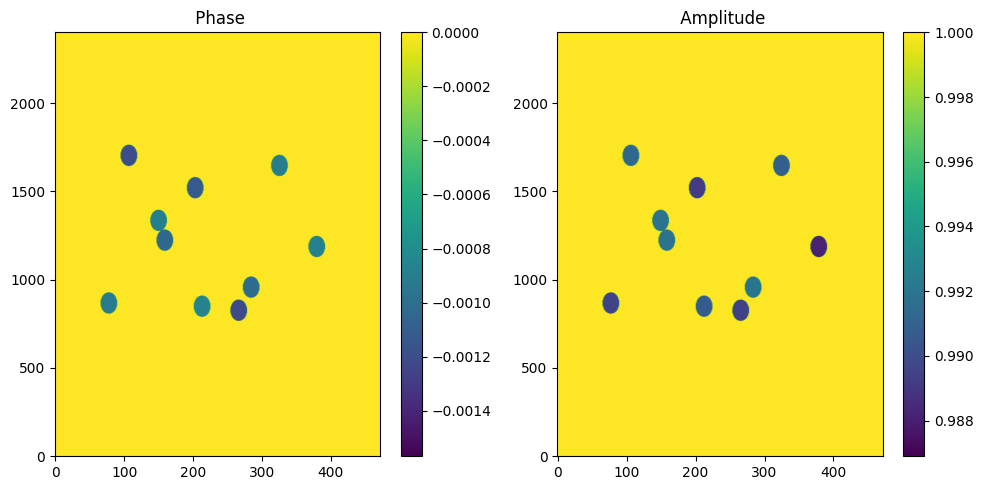

In [28]:
ptycho_object = create_ptycho_object(simulation_space)

# # Base refractive index offsets
delta = 0.01
beta = 0.001

# # Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length_factor=common_side_length,
        centre_factor=(cx, cz),
        depth_factor=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# ptycho_object.create_refractive_index_of_phantom(
#     real_perturbation=delta,
#     imaginary_perturbation=beta
# )
simulation_space.viewer.plot_two_panels(ptycho_object.refractive_index, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [29]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

Forward model creation and solving time: 8.78 seconds.



In [30]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 use_pit=False)

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=True)
# intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=False)

In [31]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 use_pit=True,
#                                 alpha=1e-6,
#                                 atol=1e-8,
#                                 num_workers=8)

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=True)
# intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=False)


# #error = np.linalg.norm(u_pwe_full - u_pwe) / np.linalg.norm(u_pwe)

In [32]:
# print("Relative error between full and iterative PWE solutions:", error)

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


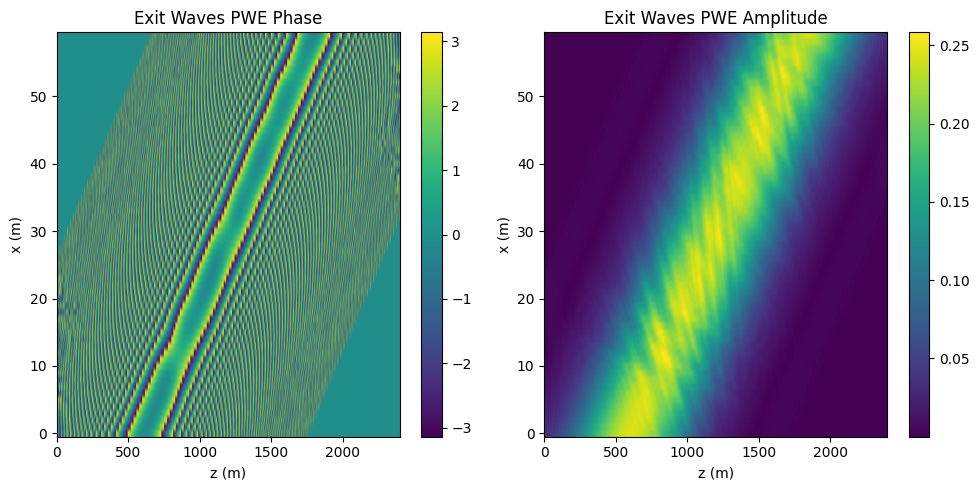

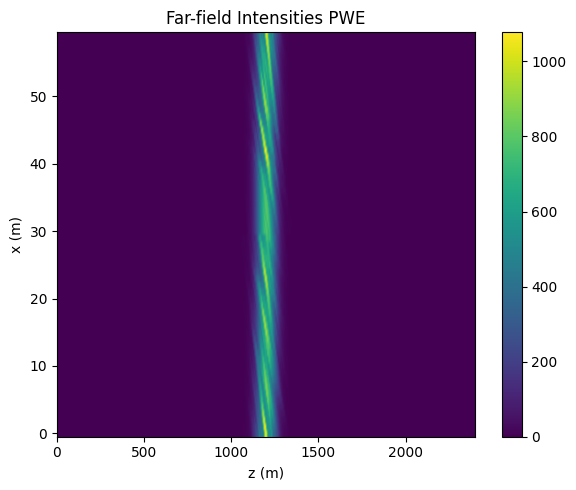

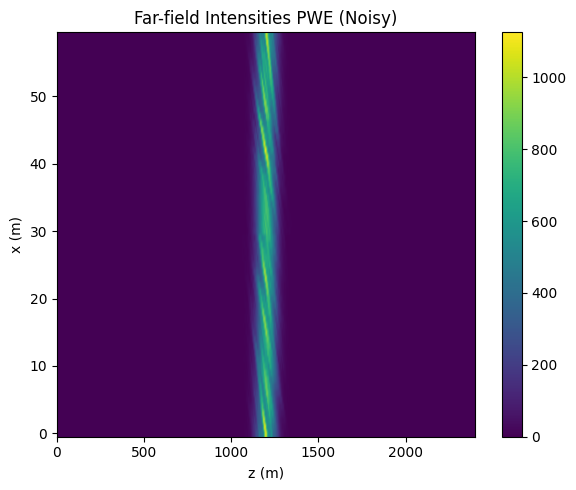

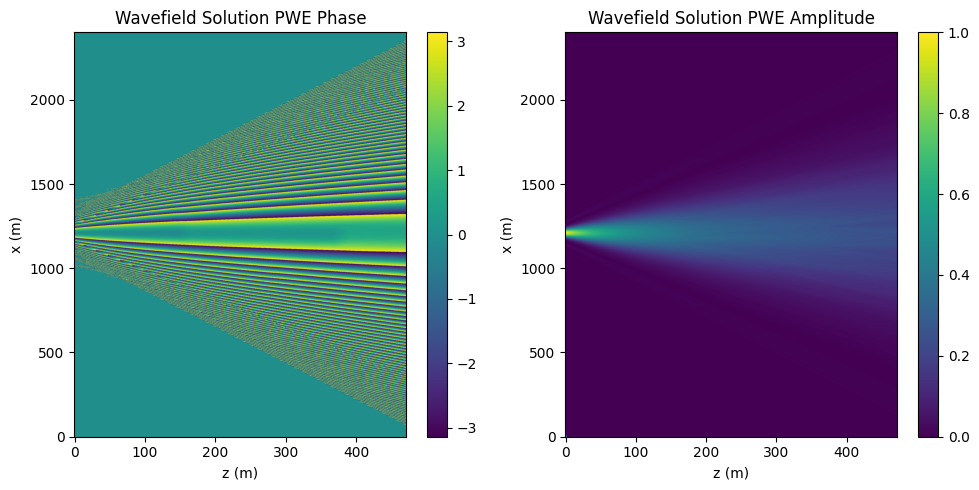

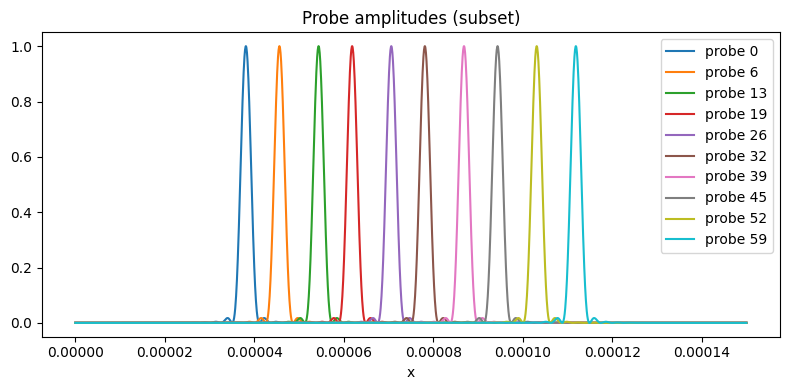

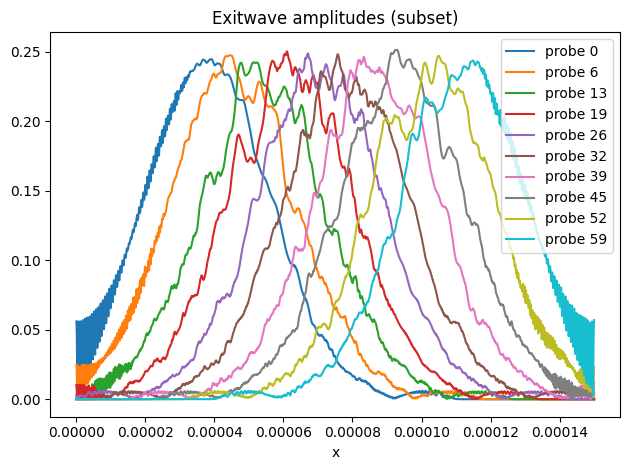

In [33]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe_noisy),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = 10#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend() 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend() 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [34]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [35]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization, 
# object domain.
# Solver parameters are defined in the solver classes.
sim_config_ms = SimulationConfig(
    probe_config=probe_config,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    nz = 50,  # Override for number of z-slices
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_ms = create_simulation_space(sim_config_ms)
simulation_space_ms.summarize()
print("Padding/Overlap:", simulation_space_ms.nx - simulation_space_ms.min_nx)

2025-12-03 13:48:02,635 - INFO - === Scan Summary (Continuous) ===
2025-12-03 13:48:02,639 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-03 13:48:02,641 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-03 13:48:02,644 - INFO -   Sample Pixels:          2401
2025-12-03 13:48:02,645 - INFO -   Number of scan points:  60
2025-12-03 13:48:02,647 - INFO -   Steps in z:             50
2025-12-03 13:48:02,649 - INFO -   Probe diameter:         5.000e-06 m
2025-12-03 13:48:02,650 - INFO -   Probe Pixels:          80 px
2025-12-03 13:48:02,656 - INFO -   Max Overlap:            3.750e-06 m
2025-12-03 13:48:02,658 - INFO -   Percentage Overlap:     75.00%



Padding/Overlap: 1201


Initialized Multislice 3PIE Reconstructor.


[Iter 001] Mean Loss = 418.2686333569978
[Iter 002] Mean Loss = 408.4066767016276
[Iter 003] Mean Loss = 403.2043102013446
[Iter 004] Mean Loss = 399.6682227730761
[Iter 005] Mean Loss = 396.9963028729842
[Iter 006] Mean Loss = 394.8537408578407
[Iter 007] Mean Loss = 393.0685066835878
[Iter 008] Mean Loss = 391.54048287852
[Iter 009] Mean Loss = 390.206295662708
[Iter 010] Mean Loss = 389.0233118894676
Reconstruction time: 17.97 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

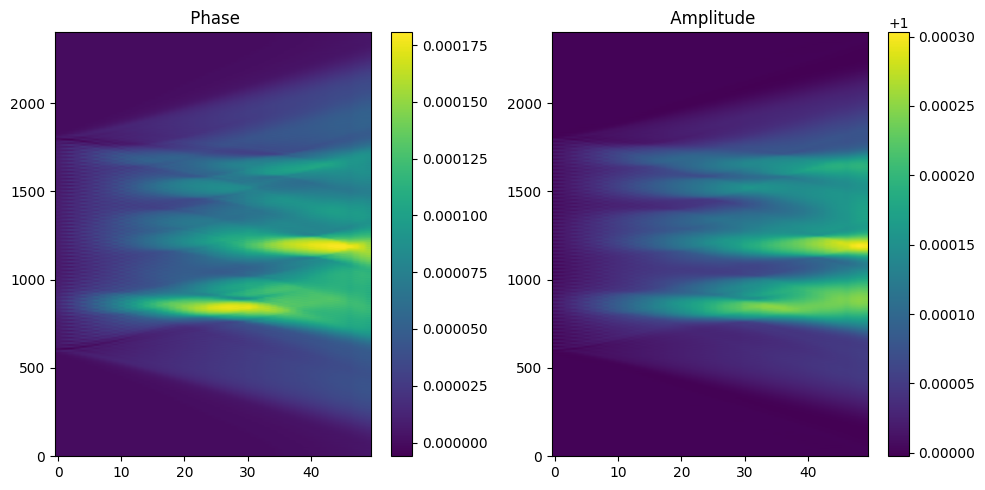

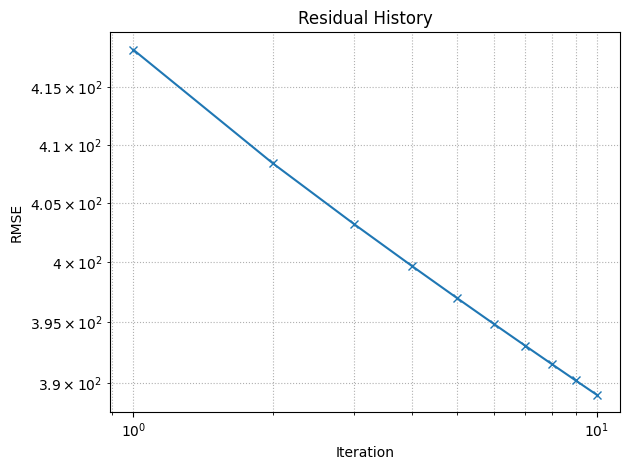

In [36]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=False)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

## Phase Retrieval

In [ ]:
# --- Reconstruction data ---
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.017884813529584938
[Iter 006] Mean Loss = 0.017199475839698115
[Iter 011] Mean Loss = 0.017032070605900698
[Iter 016] Mean Loss = 0.016941701739006696
Reconstruction time: 3.40 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

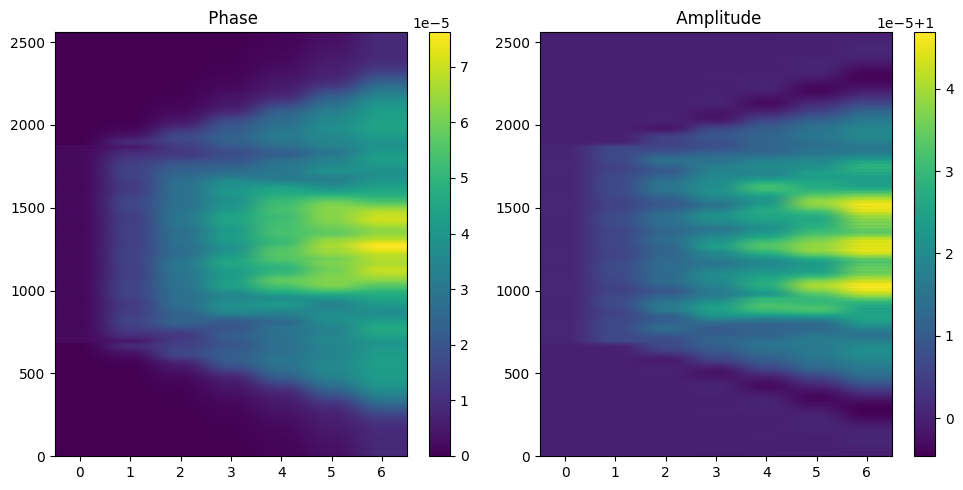

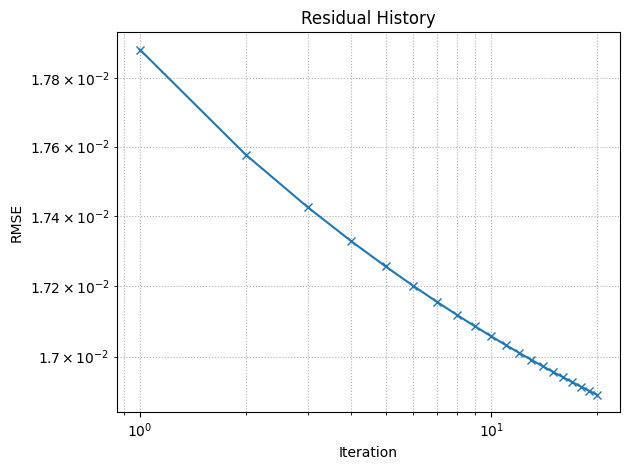

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=False)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=20,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.010401956147502299
    Iteration 1 took 11.90 seconds.
Iteration 2/10
    RMSE: 0.01018310853325468
    Iteration 2 took 12.38 seconds.
Iteration 3/10
    RMSE: 0.009971862531211712
    Iteration 3 took 13.35 seconds.
Iteration 4/10
    RMSE: 0.009761173863354353
    Iteration 4 took 12.62 seconds.
Iteration 5/10
    RMSE: 0.009550910617586924
    Iteration 5 took 12.15 seconds.
Iteration 6/10
    RMSE: 0.009340796765383705
    Iteration 6 took 12.35 seconds.
Iteration 7/10
    RMSE: 0.00913053062841343
    Iteration 7 took 12.86 seconds.
Iteration 8/10
    RMSE: 0.00891977570480573
    Iteration 8 took 12.51 seconds.
Iteration 9/10
    RMSE: 0.00870815307532686
    Iteration 9 took 12.13 seconds.
Iteration 10/10
    RMSE: 0.008495231747814693
    Iteration 10 took 12.95 seconds.
Reconstruction time: 125.22 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

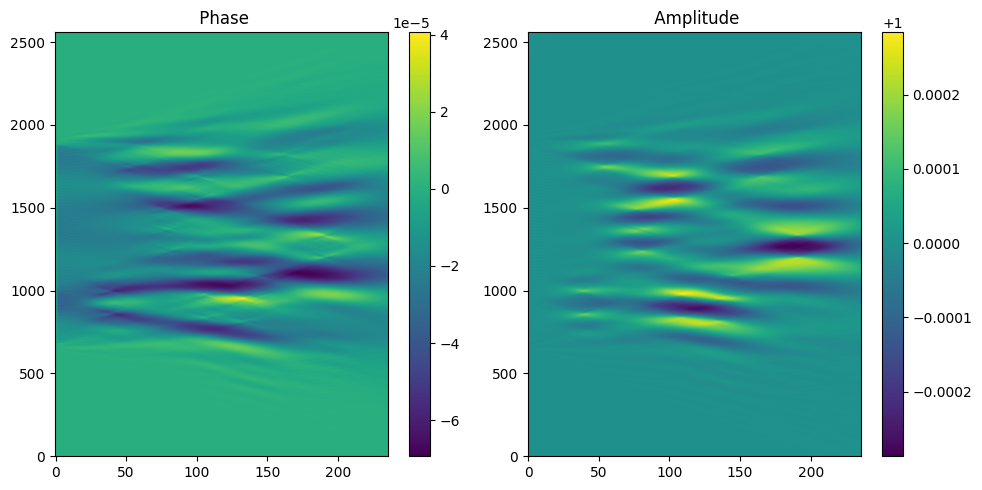

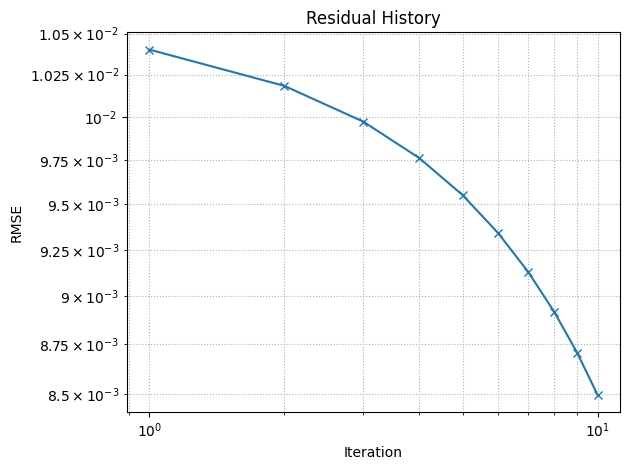

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=False)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)

data = rng.poisson(intensities_pwe) 


Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.01962404393470194
[Iter 002] Mean Loss = 0.019554248667394476
[Iter 003] Mean Loss = 0.01951618890292078
[Iter 004] Mean Loss = 0.019489777856402983
[Iter 005] Mean Loss = 0.01946951037844823
[Iter 006] Mean Loss = 0.01945305569191614
[Iter 007] Mean Loss = 0.019439202663445357
[Iter 008] Mean Loss = 0.019427239720302376
[Iter 009] Mean Loss = 0.019416712706494855
[Iter 010] Mean Loss = 0.019407313854784995
Reconstruction time: 1.35 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

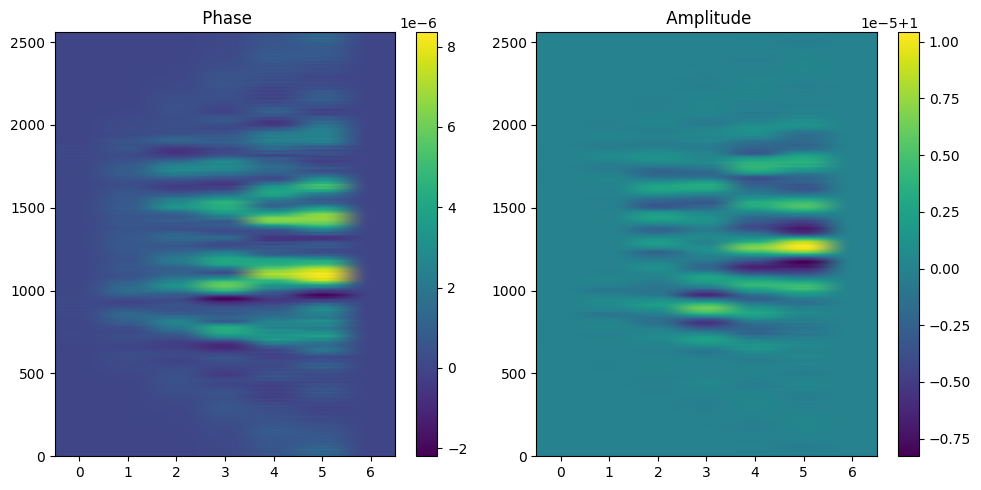

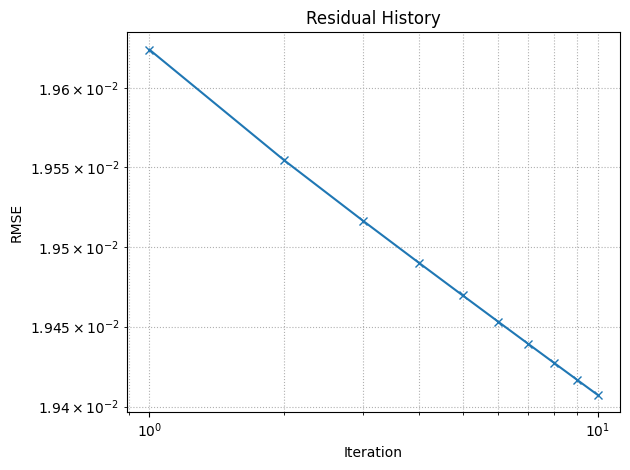

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=False)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.01094436217473302
    Iteration 1 took 12.73 seconds.
Iteration 2/10
    RMSE: 0.01073237525480603
    Iteration 2 took 14.09 seconds.
Iteration 3/10
    RMSE: 0.010528185996042258
    Iteration 3 took 12.28 seconds.
Iteration 4/10
    RMSE: 0.010324998861557595
    Iteration 4 took 12.83 seconds.
Iteration 5/10
    RMSE: 0.010122709067034613
    Iteration 5 took 13.72 seconds.
Iteration 6/10
    RMSE: 0.009921078330348729
    Iteration 6 took 13.49 seconds.
Iteration 7/10
    RMSE: 0.009719849440106268
    Iteration 7 took 15.33 seconds.
Iteration 8/10
    RMSE: 0.009518738923357313
    Iteration 8 took 14.17 seconds.
Iteration 9/10
    RMSE: 0.009317431663726257
    Iteration 9 took 14.74 seconds.
Iteration 10/10
    RMSE: 0.009115574223870927
    Iteration 10 took 13.36 seconds.
Reconstruction time: 136.79 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

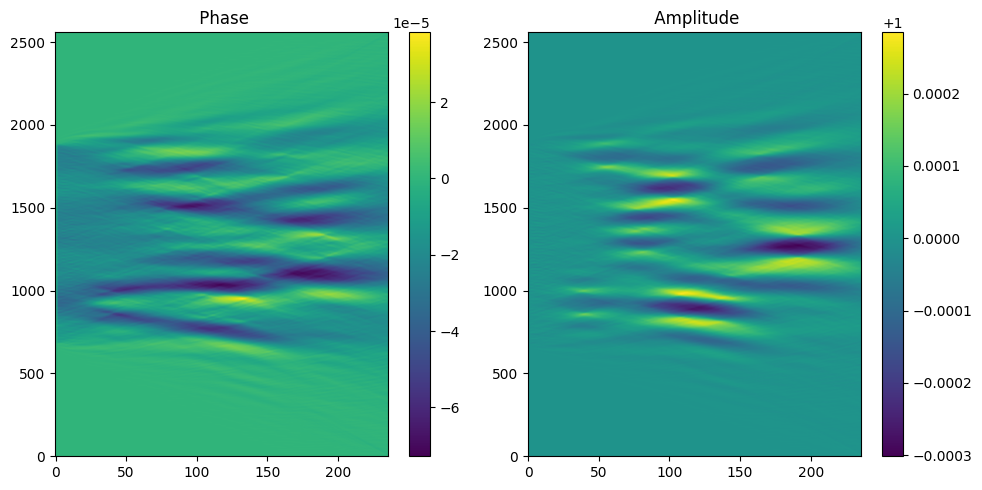

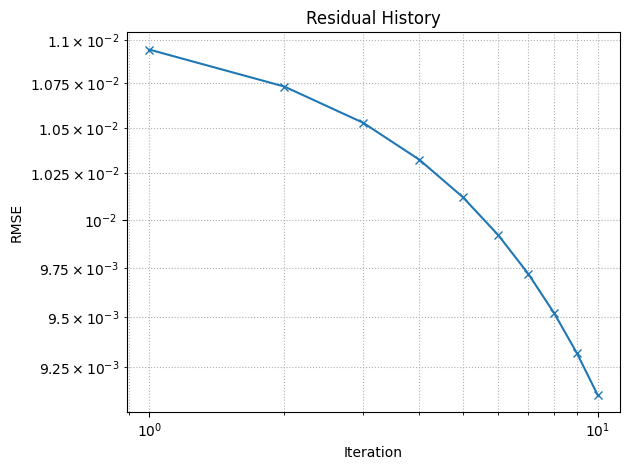

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=False)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)